In [2]:
%load_ext autoreload
%autoreload 2
from agox.modules.models.descriptors.exponential_density import ExponentialDensity
#from agox.modules.models.descriptors.soap import SOAP
from agox.modules.generators.complementary_energy.ce_gauss import ComplementaryEnergyCalculator, ComplementaryEnergyGenerator, ComplementaryEnergyDistanceCalculator, ComplementaryEnergyDistanceSquaredCalculator
from ase.build import molecule
import numpy as np
from agox.modules.helpers.plot_confinement import plot_atoms, plot_cell
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
!pwd

/home/machri/PythonPackages/agox/agox/modules/generators/complementary_energy


In [3]:
def calculate_grid(calculator, atoms, move_index, n=50):
    dx = cell_size / n
    d0 = dx / 2

    ce_map = np.zeros((n, n))

    atoms.set_calculator(calculator)

    for i in range(n):
        for j in range(n):
            x = d0 + i * dx
            y = d0 + j * dx

            atoms.positions[move_index, 0] = x
            atoms.positions[move_index, 1] = y

            ce_map[i, j] = atoms.get_potential_energy()
    return ce_map

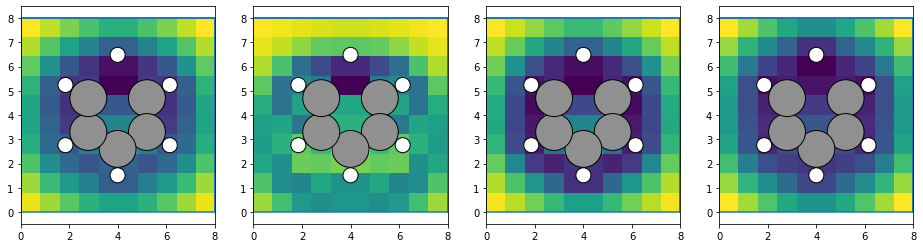

In [5]:

ncols = 4
nrows = 1
sz = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*sz, nrows*sz))
axes = axes.flatten()

# Cell & Atoms
cell_size = 8
atoms = molecule('C6H6')
atoms.set_cell(np.eye(3)*cell_size)
atoms.positions += -atoms.get_center_of_mass() + cell_size / 2

# Attractors:
pristine_atoms = atoms.copy()
descriptor = ExponentialDensity([1, 6], sigma=[0.5, 1, 2])
#descriptor = SOAP(species=['H', 'C'])
F = descriptor.get_feature(pristine_atoms)
attractors = [F[0, :]]

# Calculators: 

calculators = [ComplementaryEnergyDistanceCalculator(descriptor, attractors)]
calculators += [ComplementaryEnergyCalculator(descriptor, attractors, sigma=sigma) for sigma in [0.1, 1, 10]]

base_atoms = atoms.copy()
del base_atoms[0]


for ax, calc in zip(axes, calculators):

    ce_map = calculate_grid(calc, atoms, 0, n=10)

    ax.imshow(ce_map.T, origin='lower', extent=[0, cell_size, 0, cell_size])

    #ax.contourf(ce_map.T, origin='lower', extent=[0, cell_size, 0, cell_size], color='black')

    plot_atoms(base_atoms, ax)
    plot_cell(ax, base_atoms.cell, np.array([0, 0, 0]))



In [6]:
from ase.constraints import FixedPlane, FixAtoms

from ase.optimize import BFGS

constraint = [FixedPlane(a, (0, 0, 1)) for a in range(12)]

#constraint += [FixAtoms(indices=list(range(1, 12)))]


In [7]:
def make_relaxation(start, calc, fmax=0.05):

    atoms = start.copy()

    atoms.set_calculator(calc)
    atoms.set_constraint(constraint)

    optimizer = BFGS(atoms)

    optimizer.run(fmax=fmax, steps=200)

    end = atoms.copy()

    return end

In [8]:

F = descriptor.get_feature(pristine_atoms)
attractors = [F[0, :], F[6, :]]


np.random.seed(42)

atoms = pristine_atoms.copy()
atoms.positions[:, 0:2] += np.random.rand(2*12).reshape(12, 2)
start = atoms.copy()

calculators = []
#calculators += [ComplementaryEnergyDistanceCalculator(descriptor, attractors)]
calculators += [ComplementaryEnergyDistanceSquaredCalculator(descriptor, attractors)]
#calculators += [ComplementaryEnergyCalculator(descriptor, attractors, sigma=sigma) for sigma in [0.1, 1, 10]]

ends = []

#fmaxes = [0.5, 0.5, 0.5, 0.5, 0.5]
fmaxes = [0.1]

for calc, fmax in zip(calculators, fmaxes):

    end = make_relaxation(start, calc, fmax)

    ends.append(end)


      Step     Time          Energy         fmax
BFGS:    0 09:31:28        1.918998        3.3017
BFGS:    1 09:31:28        1.537595        2.4180
BFGS:    2 09:31:28        0.679055        0.8408
BFGS:    3 09:31:28        0.438300        0.5729
BFGS:    4 09:31:28        0.353075        0.5266
BFGS:    5 09:31:29        0.324206        0.4909
BFGS:    6 09:31:29        0.285388        0.5421
BFGS:    7 09:31:29        0.227410        0.5158
BFGS:    8 09:31:29        0.168009        0.3633
BFGS:    9 09:31:30        0.134728        0.2884
BFGS:   10 09:31:30        0.126095        0.2587
BFGS:   11 09:31:30        0.118622        0.2300
BFGS:   12 09:31:30        0.100593        0.2101
BFGS:   13 09:31:30        0.079611        0.1968
BFGS:   14 09:31:31        0.065400        0.1559
BFGS:   15 09:31:31        0.061148        0.1465
BFGS:   16 09:31:31        0.058480        0.1441
BFGS:   17 09:31:31        0.054093        0.1271
BFGS:   18 09:31:31        0.046276        0.1048
B

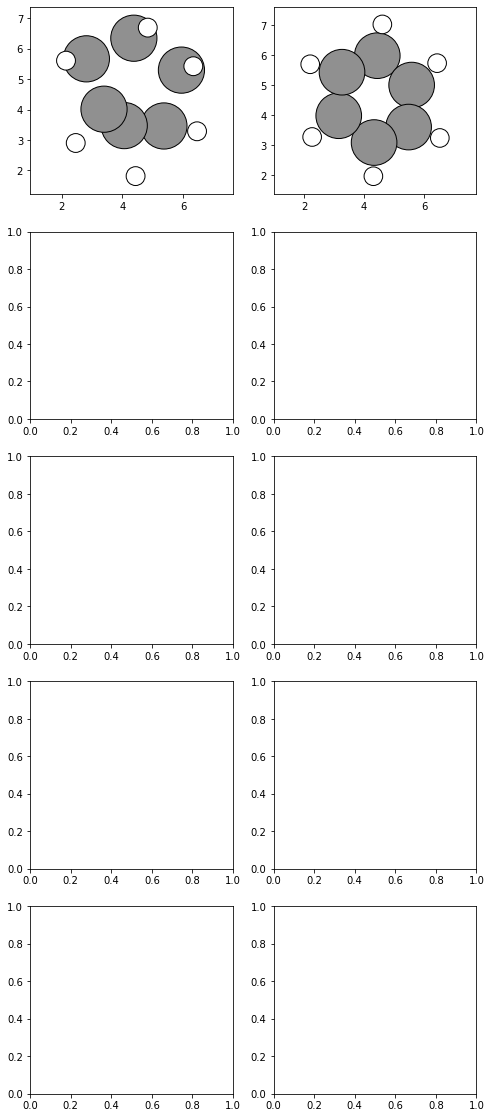

In [9]:
sz = 4
fig, ax = plt.subplots(5, 2, figsize=(2*sz, 5*sz))

for i, end in enumerate(ends):

    plot_atoms(start, ax[i, 0])
    plot_atoms(end, ax[i, 1])

In [121]:
np.random.rand(10)

array([0.02954123, 0.55414439, 0.19861435, 0.37017379, 0.90897609,
       0.45644292, 0.26186811, 0.5487804 , 0.58618736, 0.79527906])